# Fase 1 - SVM con ProfilingUD (cross-genre classification)
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata solo su informazioni linguistiche non lessicali estratte utilizzando il sistema Profiling-UD. Riportare i seguenti risultati:

- valutazione del sistema con un processo di 5-fold cross validation condotto sul training set;
- valutazione del sistema sul test set ufficiale del task;
- elenco delle 15 feature più importanti per la classificazione

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways:

1. using a model which has been trained on the same genre
2. **using a model which has been trained on anything but that genre."**

In questo file utilizzeremo un modello allenato su generi diversi da quello su cui poi verrà testato.

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## Preparazione del dataset

In [6]:
# Percorsi ai file per ogni genere
GENRES = ["children", "diary", "journalism", "twitter"]
gold_file_path = "../data/original/gold/test_{}.gold"
profiling_output_base = '../data/profiling_output/{}/linguistic_profile.csv'

In [8]:
# Funzione per caricare un dataset di un dato genere
def load_dataset(genre):
    src_path = profiling_output_base.format(genre)
    features_names = None
    documents_info = [] # nomi dei file di ogni documento
    features = [] # matrice delle feature per ogni documento

    # row[0] è ['Filename', 'n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'ttr_lemma_chunks_100', 'ttr_lemma_chunks_200', 'ttr_form_chunks_100', ...
    # row[1] è ['children/training#66#children#F.conllu', '21', '396', '18.857142857142858', '4.227528089887641', '0.68', ...
    # row[2] è ['children/test#133#children#unknown.conllu', '13', '328', '25.23076923076923', '3.99672131147541', '0.52', ...
    # etc ...
    
    with open(src_path, 'r') as src_file:
        csv_reader = csv.reader(src_file, delimiter='\t')
        for row in csv_reader:
            if features_names is None: # la prima riga del csv contiene 'Filename' e tutti i nomi delle features (la prima volta che entro nel ciclo ho feature_name ancora inizializzato a None, e quindi uso questa condizione per iniziare a popolare l'array
                features_names = row[1:]  # estraggo le feature, ovvero salto la prima colonna dove è contenuto il nome del file
            else:
                documents_info.append(row[0])  # il primo elemento di ogni riga contiene il nome del file children/training#66#children#F.conllu dove sono codificati il genere, lo split e i velori numerici delle feature
                features.append([float(el) for el in row[1:]]) # dal secondo elemento in poi ci sono i nomi delle feature perché il primo è il nome del file
    return features_names, documents_info, features    


Training su tutti i generi tranne: CHILDREN

GENERI USATI PER IL TRAINING: ['diary', 'journalism', 'twitter']
GENERE USATO PER IL TEST: children
Feature Training Unique Lengths: {136, 139, 140}
Feature Test Unique Lengths: {136, 139, 140}

=== Dimensioni dei Fold ===
Fold 1: Training set = 5120, Test set = 1280
Fold 2: Training set = 5120, Test set = 1280
Fold 3: Training set = 5120, Test set = 1280
Fold 4: Training set = 5120, Test set = 1280
Fold 5: Training set = 5120, Test set = 1280
Accuracy fold 1: 0.61640625, baseline dummy: 0.484375
Accuracy fold 2: 0.61875, baseline dummy: 0.46875
Accuracy fold 3: 0.63984375, baseline dummy: 0.48671875
Accuracy fold 4: 0.61875, baseline dummy: 0.49765625
Accuracy fold 5: 0.6078125, baseline dummy: 0.4953125

=== Risultati della 5-Fold Cross Validation ===
              precision    recall  f1-score   support

           F       0.62      0.61      0.62      3200
           M       0.62      0.63      0.62      3200

    accuracy              

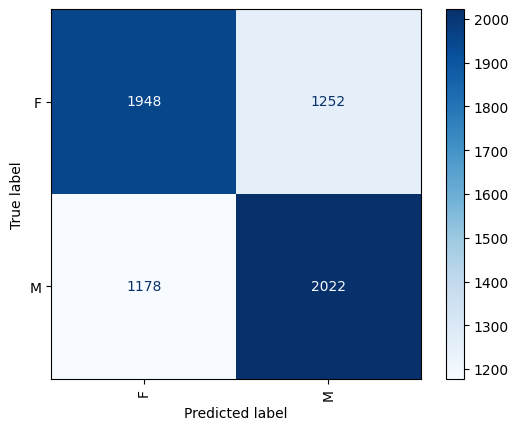

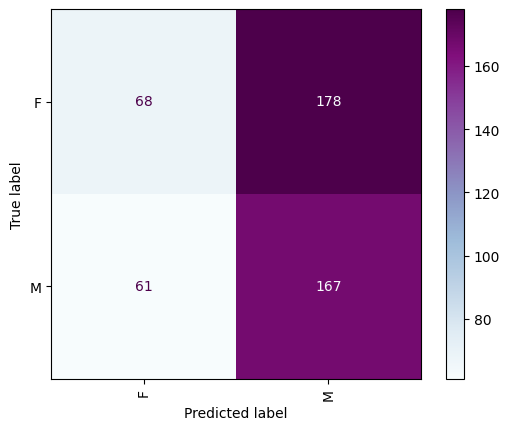

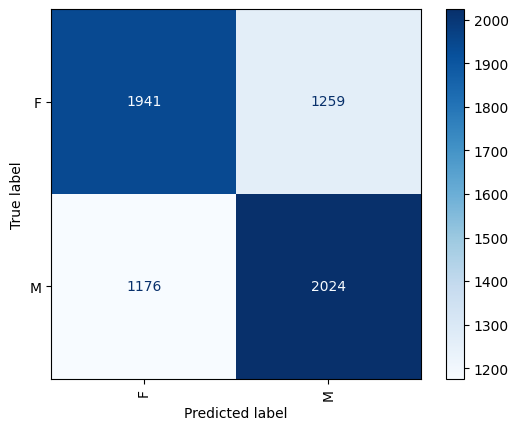

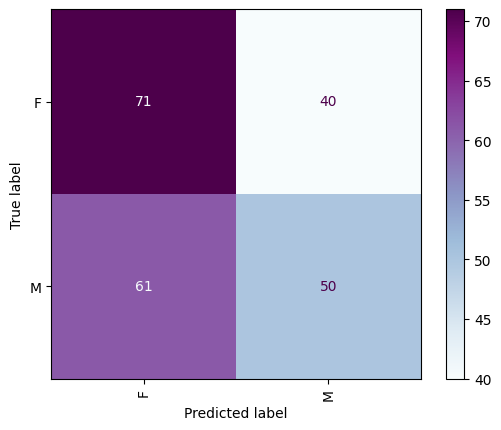

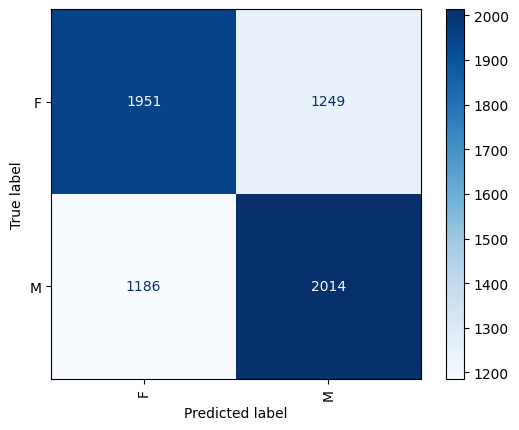

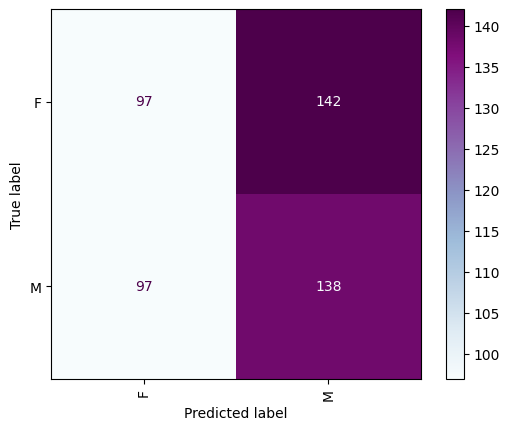

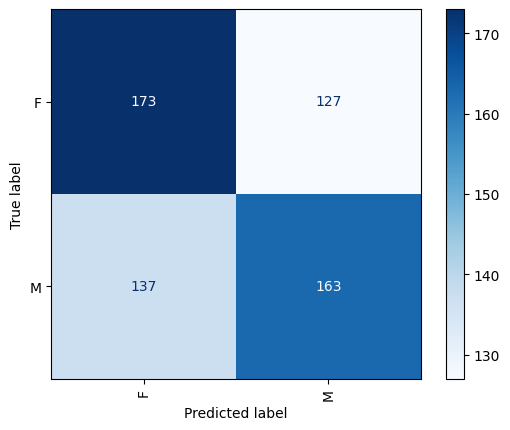

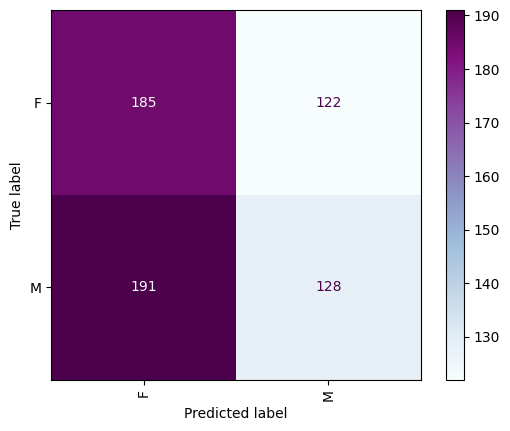

In [24]:
# Cross-Genre Training
for test_genre in GENRES:
    print(f"\nTraining su tutti i generi tranne: {test_genre.upper()}") # stampa in maiuscolo il genere escluso (sarà il test)

    #  Caricare dati per tutti i generi
    train_features, train_labels, test_features, test_filenames = [], [], [], []
    training_genres_used = [] # generi usati per il training

    for genre in GENRES:
        features_names, documents_info, features = load_dataset(genre)
        
        # Estrarre le etichette M/F, unknown è del test set
        labels = [] # salva le etichette M7F
        selected_features = []  # salva le feature dei documenti con etichettta M/F, lo usiamo questa per evitare mismatch con labels

        
        for idx, doc in enumerate(documents_info):  
            # children/training#66#children#F.conllu
            filename = doc.split('/')[-1]  # training#66#children#F.conllu
            filename_no_ext = filename.replace('.conllu', '')  # training#66#children#F
            file_parts = filename_no_ext.split('#')  # ['training', '66', 'children', 'F']
            gender = file_parts[-1] #M o F o unknown
            
            # Separiamo i file di test da quelli di training 
            if gender == "unknown":
                test_features.append(features[idx])  # uso l'indice preso dal for
                test_filenames.append(doc)
            else:
                labels.append(gender)  # aggiungo il file al training set
                selected_features.append(features[idx])
                
        if genre != test_genre:
            train_features.extend(selected_features)
            train_labels.extend(labels)
            training_genres_used.append(genre)


    # Debug: Verifica che il genere escluso non venga usato
    print(f"\nGENERI USATI PER IL TRAINING: {training_genres_used}")
    print(f"GENERE USATO PER IL TEST: {test_genre}")

        # Controllo della lunghezza delle features e padding delle features
    feature_lengths = []
    test_feature_lengths = []
    
    # Ciclo per il training set
    for f in train_features:
        lunghezza = len(f)  # Calcola la lunghezza del vettore delle feature
        feature_lengths.append(lunghezza)  # Aggiunge la lunghezza alla lista
    
    # Ciclo per il test set
    for f in test_features:
        lunghezza = len(f)  # Calcola la lunghezza del vettore delle feature
        test_feature_lengths.append(lunghezza)  # Aggiunge la lunghezza alla lista


    unique_train_lengths = set(feature_lengths) 
    unique_test_lengths = set(test_feature_lengths)
    
    print(f"Feature Training Unique Lengths: {unique_train_lengths}")
    print(f"Feature Test Unique Lengths: {unique_test_lengths}")
    # Ad esempio, per children:
    # Feature Training Unique Lengths: {136, 139, 140}
    # Feature Test Unique Lengths: {136, 139, 140}
    # Nel dataset ci sono tre features con lunghezze diverse, dobbiamo correggere il problema con un padding di 0 nelle lunghezze più 

    # Se le lunghezze non sono uguali, facciamo il padding per uniformarle
    max_length = max(max(feature_lengths), max(test_feature_lengths)) # lunghezza massima tra tutte le features

    # Padding per il training set
    padded_train_features = []
    for f in train_features:
        lunghezza_attuale = len(f)  # Misura la lunghezza attuale della feature in train_features
        padding_necessario = max_length - lunghezza_attuale  # Calcola quanti 0 servono
        vettore_padded = f + [0] * padding_necessario  # Aggiunge gli 0 alla fine
        padded_train_features.append(vettore_padded)  # Salva il nuovo vettore
    
    # Padding per il test set
    padded_test_features = []
    for f in test_features:
        lunghezza_attuale = len(f)  # Misura la lunghezza attuale della feature in test_features
        padding_necessario = max_length - lunghezza_attuale  # Calcola quanti 0 servono
        vettore_padded = f + [0] * padding_necessario  # Aggiunge gli 0 alla fine
        padded_test_features.append(vettore_padded)  # Salva il nuovo vettore
    
    # Sostituiamo le vecchie liste con le nuove
    train_features = padded_train_features
    test_features = padded_test_features


    train_features = np.array(train_features, dtype=np.float64) # SVM in scikit-learn richiede un array NumPy o df Pandas per l'addestramento
    test_features = np.array(test_features, dtype=np.float64)

    
    # 5-Fold Cross Validation sul Training Set
    y_train = np.asarray(train_labels) # converto le etichette del training set in formato Numpy compatibile con scikit-learn
    splitter = KFold(n_splits=5, random_state=42, shuffle=True)
    folds = list(splitter.split(train_features))

    print("\n=== Dimensioni dei Fold ===")
    for i in range(len(folds)):
        print(f"Fold {i+1}: Training set = {len(folds[i][0])}, Test set = {len(folds[i][1])}") # stampa n. di doc di training e test per ogni fold

    all_y_true = [] # etichette reali dei fold
    all_y_pred = [] # etichette predette dal modello
    # alla fine della 5 fold, queste liste conterranno tutte le predizioni sui vari fold

    for i in range(len(folds)):
        train_ids, test_ids = folds[i] # train_ids e test_ids contengono gli indici dei dati di training e test per quel fold

        # estraggo i dati di training e test usando gli indici ⬆
        fold_X_train = train_features[train_ids]
        fold_y_train = y_train[train_ids]
        fold_X_test = train_features[test_ids]
        fold_y_test = y_train[test_ids]

        # normalizzazione delle features in ogni fold
        scaler = MinMaxScaler()
        fold_X_train = scaler.fit_transform(fold_X_train)
        fold_X_test = scaler.transform(fold_X_test) 

        # allenamento SVM e predizioni sul test in ogni fold
        kfold_svc = LinearSVC(dual=False) # dual=False perché il numero di campioni è maggiore del numero di feature
        kfold_svc.fit(fold_X_train, fold_y_train)
        fold_y_pred = kfold_svc.predict(fold_X_test)

        # calcolo accuratezza con etichette reali della fold test
        fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)

        # baseline con DummyClassifier
        dummy_clf = DummyClassifier(strategy="most_frequent")
        dummy_clf.fit(fold_X_train, fold_y_train)
        dummy_score = dummy_clf.score(fold_X_test, fold_y_test)

        # alla fine della cross validation queste due liste contengono tutte le etichette e le predizioni dei fold combinati
        all_y_true += fold_y_test.tolist()
        all_y_pred += fold_y_pred.tolist()

        print(f"Accuracy fold {i+1}: {fold_accuracy}, baseline dummy: {dummy_score}")

    print("\n=== Risultati della 5-Fold Cross Validation ===")
    print(classification_report(all_y_true, all_y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, xticks_rotation='vertical', cmap='Blues')
    # FINE DELLA 5 FOLD CROSS VALIDATION


    
    # INIZIO UTILIZZO TUTTO TRAINING SET PER ALLENAMENTO, TEST SET E GOLD PER VALUTAZIONE
    
    # Normalizzazione per il test finale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_features)
    X_test = scaler.transform(test_features)

    # Addestramento finale dell'SVM
    svc = LinearSVC(dual=False)
    svc.fit(X_train, train_labels)

    # Predizione sul test set
    test_predictions = svc.predict(X_test)

    # Allenamento e predizioni del DummyClassifier
    dummy_clf.fit(X_train, train_labels)
    dummy_predictions = dummy_clf.predict(X_test)

    # Confronto con il GOLD dataset (dato che i nomi dei file non sono nel formato test_{GENRE} creo un dizionario per collegare il genere al gold
    gold_file_map = {
        "children": "test_CH.gold",
        "journalism": "test_JO.gold",
        "diary": "test_DI.gold",
        "twitter": "test_TW.gold"
    }
    
    # Controlliamo che il genere sia presente nella mappa
    if test_genre in gold_file_map:
        gold_filename = gold_file_map[test_genre]
        gold_df = pd.read_csv(f"../data/original/gold/{gold_filename}", delimiter="\t", names=["ID", "True_Gender"])
    else:
        raise ValueError(f"ATTENZIONE! Nome del file GOLD non trovato per il genere: {test_genre}")
    
    test_ids = []  # Creiamo una lista vuota per salvare gli ID dei file di test 
    for name in test_filenames:
        parts = name.split("#")  # Divide il nome del file in parti
        doc_id = parts[1]  # Prende il secondo elemento, che è l'ID
        test_ids.append(doc_id)  # Aggiunge l'ID alla lista

    # Creo un df con le predizioni 
    df_output = pd.DataFrame({"ID": test_ids, "Predicted_Gender": test_predictions})
    dummy_output = pd.DataFrame({"ID": test_ids, "Dummy_Gender": dummy_predictions})

    # Converto gli ID in stringhe per fare il merge dopo (sennò errore)
    df_output["ID"] = df_output["ID"].astype(str)
    gold_df["ID"] = gold_df["ID"].astype(str)

    # merge delle predizioni con il gold dataset
    merged_df = pd.merge(df_output, gold_df, on="ID")
    merged_dummy_df = pd.merge(dummy_output, gold_df, on="ID")

    # Confronto tra le predizioni e il gold
    accuracy = accuracy_score(merged_df["True_Gender"], merged_df["Predicted_Gender"])
    dummy_accuracy = accuracy_score(merged_dummy_df["True_Gender"], merged_dummy_df["Dummy_Gender"])
    
    print(f"\n=== Risultati sul Test Set ({test_genre.upper()}) ===")
    print(f" Accuratezza SVM: {accuracy:.4f}")
    print(f" Accuratezza Dummy: {dummy_accuracy:.4f}")

    # Il classification report include: precision, recall, f1-score
    print(classification_report(merged_df["True_Gender"], merged_df["Predicted_Gender"]))

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        merged_df["True_Gender"], merged_df["Predicted_Gender"], xticks_rotation='vertical', cmap='BuPu'
    );

    '''
    Stampo due confusion matrix per ogni genere di test (test_genre), se abbiamo 4 generi:
    Ogni genere viene escluso una volta come test set, quindi il codice esegue 4 iterazioni.
    Stampiamo 2 confusion matrix:
        1. Dopo la k-fold cross validation -> mostra il comportamento del modello sui dati di training nei fold
        2. Durante la valutazione finale sul test set (gold) -> dopo il test sul gold
    Totale confusion matrix stampate: 4 generi × 2 confusion matrix = 8 confusion matrix
    '''